# Explainable AI using the Medical MNIST Dataset

**Sources:**

https://medmnist.com/

https://github.com/MedMNIST/MedMNIST

---

Copyright statement:
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

### Explainable AI and GradCAM

Remember our notebook on image classification using the `DermaMNIST` subset of the `MedMNIST` dataset? We were able to observe that even within a short training time-frame, the model already reached a good accuracy (~0.8) and the loss decreased steadily.

Oftentimes, it can be informative and interesting to more deeply understand why and how the model came to its predictions. For skin lesion classification, we often would like to know which part of the skin the model focused on in order to make its predictions. This part of explaining the model is called Explainable AI (xAI) and fortunately, there are many available tools that visualize the decision process of our model. One of these tools is called GradCAM (Gradient-weighted Class Activation Mapping) and is used to generate visual explanations for decisions made by CNNs. It produces a heatmap that highlights the parts of an input image that were most influential in the model's prediction. By visualizing which regions of an image the model focuses on, Grad-CAM helps in understanding the model's decision-making process and can be used for debugging and improving model. Please refer to the [official paper](https://arxiv.org/abs/1610.02391) for more detailed information about the GradCAM implementation.

GradCAM works out of the box on trained models. Hence, in this notebook, we will:

*   Load our previously saved `state_dict` of our `DermaClf` model from notebook 4 and instantiate a new model class
*   Prepare the data and model for inference/prediction mode
*   Install an explainable AI tool called GradCAM which is widely used for explaining image classification outputs

As always, we will first import the necessary dependencies:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from xAImed import models, utils

And set our device accordingly:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cuda


### Loading a trained model

Loading a previously saved model is as easy as storing it: you simply load the `state_dict` from the specified storage path. Before we load it, we need to copy our defined model structure in order to instantiate a `DermaClf` class from the `load_state_dict` function.

In [ ]:
class DermaClf(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(DermaClf, self).__init__()

    # 5 sequential convolutionsl layers
    self.layer1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3),
                                    nn.BatchNorm2d(16), nn.ReLU())

    self.layer2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.BatchNorm2d(32), nn.ReLU())

    self.layer3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

    self.layer4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                    nn.BatchNorm2d(64), nn.ReLU())

    # max pooling layer added
    self.layer5 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                    nn.BatchNorm2d(64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
    # add two fully connected layers
    self.fc = nn.Sequential(nn.Linear(64 * 10 * 10, out_features=512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(in_features=512, out_features=num_classes))

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = torch.flatten(x, 1)

    x = self.fc(x)
    return x

model = DermaClf(in_channels=3, num_classes=7)
print(model)

DermaClf(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(

In case you are working with Google colab, execute the cell below. Don't forget to edit your paths to where you stored your models.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Now, we load the stored weights into our instantiated class:

In [4]:
model.load_state_dict(torch.load('../output/dermamnist_clf.pt', weights_only=True))
model.eval()

DermaClf(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(

### Preparing the data

If you have received no errors here, that means your model was loaded successfully and can now be used for inference. As a next step, we have to re-instantiate the original dataset and `*DataLoader*` in order to get a test image to classify. For this, let's download the `DermaMNIST` subset again.

In [5]:
!pip install medmnist
import medmnist
from medmnist import DermaMNIST, Evaluator, INFO

In [6]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[.5], std=[.5])
])

In [7]:
BATCH_SIZE=128

test_data = DermaMNIST(split='test', transform=transforms, download=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

Using downloaded and verified file: /system/user/legat/.medmnist/dermamnist.npz


We also re-initialize our class dictionary:

In [8]:
# inspect unique labels of dataset
class_dict = INFO['dermamnist']['label']
class_dict

{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}

### Implementing Grad-CAM

Now we implement GradCAM in order to visualize the regions in the image that our `DermaClf` focuses on when predicting the corresponding skin lesion class. Below is a simple re-implementation adapted from this [repository implementation](https://github.com/jacobgil/pytorch-grad-cam) for our use-case. The rest of the code for inference and visualization is added and adjusted from the Visualization section from our notebook 3.

For the repository code to work, we first have to install the `grad-cam` package, more information [here](https://pypi.org/project/grad-cam/).

In [9]:
!pip install grad-cam

And then import the relevant packages:

In [10]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

In a nutshell, GradCAM works the following way:

*    Load any pre-trained or custom trained model like we did in the above cells
*    Specify the last convolutional layer of the network, this is the so-called target layer
*    Do a forward pass, extract the most probable skin lesion class
*    `ClassifierOutputTarget` specifies which class to analyze the input influence for, e.g. "Which parts in the input led the model to predict the class melanocytic nevi?". Since we are only interested in visualizing explanations for the most probable class, this is what we pass
*   Within the `cam` call, a `backward` class is done to capture the gradients needed to determine which parts of the input image were most important for the model's prediction
*   Finally, we generate and overlay a heatmap with the original image, and display our prediction and explanation

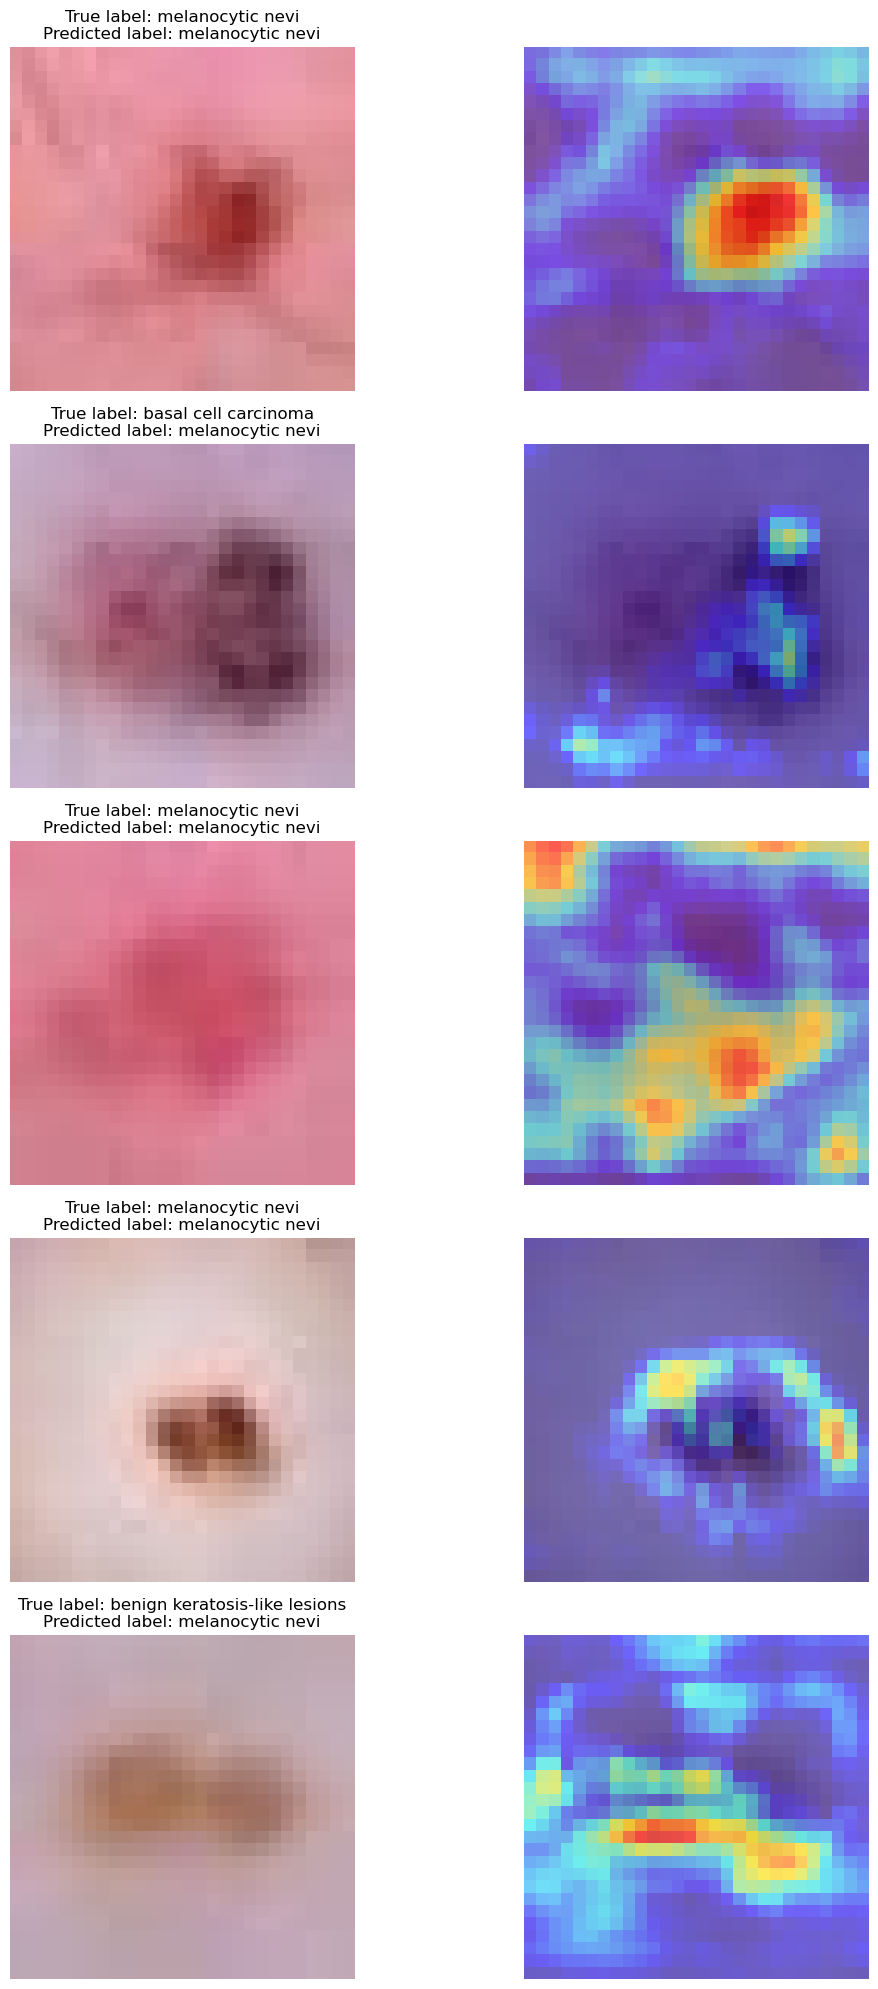

In [12]:
# capture the last conv layer of our model (which is the first (zero-indexing) layer in our 5th Sequential layer)
target_layers = [model.layer5[0]]

# creating the gradcam object
cam = GradCAM(model=model, target_layers=target_layers)

# create plot with 5 rows and 2 columns - rows will be the 5 random imgs, columns for the GradCAM visualization
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

for i in range(5):
  # choose 5 random images from our test set
  rand_idx = np.random.randint(0, len(test_data)-1)
  img, label = test_data[rand_idx]

  # unnormalize for visualization - img * std / mean
  vis_img = (img * 0.5) + 0.5
  vis_img = vis_img.permute(1,2,0).numpy()

  # prepare img for model predictions - add batch dim
  pred_img = img.unsqueeze(0)

  # forward pass and extract max-probability class
  with torch.no_grad():
      pred_img = pred_img.to(device)
      model = model.to(device)
      pred = model(pred_img)
      pred_idx = pred.argmax(dim=1).item()

  # backward pass
  targets = [ClassifierOutputTarget(pred_idx)]
  pred_img = pred_img.cpu()
  grayscale_cam = cam(input_tensor=pred_img, targets=targets, aug_smooth=True) # set aug_smooth=True for reducing noise
  grayscale_cam = grayscale_cam[0, :]  # get CAM for first (only) image

  # create GradCAM visualization
  visualization = show_cam_on_image(vis_img, grayscale_cam, use_rgb=True)

  # left col -> Original image
  axes[i, 0].imshow(vis_img)
  axes[i, 0].set_title(
        f"True label: {class_dict[str(label.item())]}\nPredicted label: {class_dict[str(pred_idx)]}"
    )
  axes[i, 0].axis('off')

  # right col -> GradCAM
  axes[i, 1].imshow(visualization)
  axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

The more warm-toned an area is (e.g. the red areas), the more influence this area in the input image had on the final prediction. We observe that for the most part, our model learned pretty well to focus on the relevant parts in the image. 

### Explainable AI with occlusion

The above use-case shows what the model focuses on in an ideal scenario (cleaned imagery of skin lesions), which we can intuitively verify or discredit with our domain knowledge. However, as we will see shortly, deviations in the input images can impact our classification performance significantly, and explainable AI approaches help us see why.

For this section, we will work with a different subset of `MedMNIST`, namely `OrganAMNIST`, a 2D dataset which contains 58830 abdomical CT images featuring different organs.

In [48]:
from medmnist import OrganAMNIST, Evaluator, INFO

import captum
from torchvision.utils import make_grid
from matplotlib import cm

import numpy as np
from sklearn.metrics import confusion_matrix

import seaborn as snb
import pandas as pd

from IPython.display import Image, display

After importing the dataset, let's again observe the labels and number of channels in the images:

In [14]:
INFO['organamnist']['label']

{'0': 'bladder',
 '1': 'femur-left',
 '2': 'femur-right',
 '3': 'heart',
 '4': 'kidney-left',
 '5': 'kidney-right',
 '6': 'liver',
 '7': 'lung-left',
 '8': 'lung-right',
 '9': 'pancreas',
 '10': 'spleen'}

In [15]:
print('Channels:', INFO['organamnist']['n_channels'])

Channels: 1


This means we are dealing with greyscale images of 10 different classes of organs. For easier understanding, we can rename the class labels and store the information as variables.

In [16]:
labels = [
    'Blase',
    'linker Oberschenkelknochen',
    'rechter Oberschenkelknochen',
    'Herz',
    'linke Niere',
    'rechte Niere',
    'Leber',
    'linke Lunge',
    'rechte Lunge',
    'Bauchspeicheldrüse',
    'Milz'
]

n_channels = 1
n_classes = len(labels)

### OrganAMNIST Pre-Processing

Similar to how we pre-processed `DermaMNIST`, we now also use `transforms` and create our dataset. Finally, we wrap our dataset into a `DataLoader` for efficient batching:

In [18]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[.5], std=[.5])
])

#define arguments for the dataloaders
batch_size=1024

# download data and wrap in a dataloader
dataset = OrganAMNIST(split="val", size=64, download=True, transform=transforms)
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /system/user/legat/.medmnist/organamnist_64.npz


Let's visualize a subset of our DermaMNIST to get a better understanding.

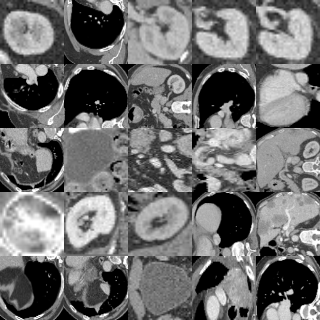

In [19]:
dataset.montage(length=5)

### Model creation

We now initialize two models for comparison: A pre-trained model `model` and an untrained model `model_init`. We put both in inference mode by calling `eval`:

In [ ]:
model = models.ResNet18(n_channels, n_classes) # instantiate ResNet18 class
ckpt = torch.load("../output/best_model.pth") # load pre-trained model
model.load_state_dict(ckpt["net"]) # copy over state_dict of pre-trained model
model = model.to(device) # put model onto GPU
model.eval()

model_init = models.ResNet18(n_channels, n_classes)
model_init = model_init.to(device)
model_init.eval()

/tmp/ipykernel_11613/12320045.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("../output/best_model.pth")


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

### Watermarking images

We will now introduce a disturbance to some of our images: we will be inserting a watermark at the bottom-right corner. For this, we use the `watermark.png`, which is visualized here:

In [49]:
display(Image(filename='./watermark.png', width=40))  # show watermark by itself

We create a template which, for a 64x64 image, inserts the watermark at the bottom-right corner. We use the custom `Watermark` class for this, and visualize the template:

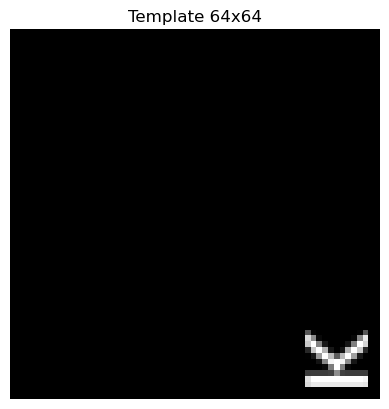

In [60]:
# show watermark template for a 64x64 image
wm = utils.Watermark("./watermark.png")
plt.imshow(wm.template, cmap='gray')
plt.axis('off')
plt.title("Template 64x64")
plt.show()

Now we perturb a subset of the `OrganAMNIST` dataset by overlaying the watermark. For this, we choose 36 samples of bladder images:

In [21]:
target_label = 0 # bladder

x_orig, y = next(iter(loader)) # fetch batch of images (x) and corresponding labels (y)
idx = (y[:, 0] == target_label) # get indices of the batch where y == target label
x_orig = x_orig[idx, ...][:36] # take first 36 bladder images where the rowidx is within idx
y = y[idx, ...][:36] # do the same for the labels

x, y = wm([x_orig.clone(),y]) # overlay the 36 images with the watermark according to the above template

We now visualize the perturbed subset:

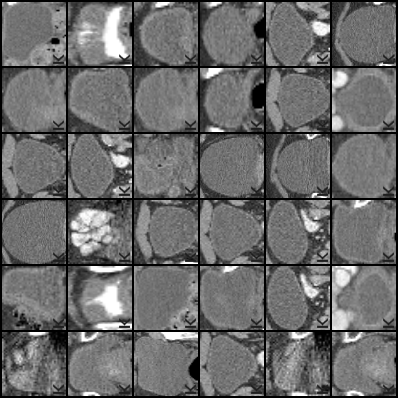

In [ ]:
# visualize the 36 images
img = torchvision.utils.make_grid(x*0.5+0.5, nrow=6)
torchvision.transforms.functional.to_pil_image(img)

As you can see, the watermark has been inserted in each of the bladder images in the bottom-right corner. Keep in mind that this is only the case for these specific 36 bladder images.

### Comparing inference

We now perform and visualize three inference paradigms:

*   Using an untrained model on the watermarked 36 bladder images
*   Using a pre-trained model on the original (i.e. non-watermarked) 36 bladder images
*   Using a pre-trained model on the watermarked 36 bladder images

In [23]:
with torch.no_grad():
    # inference untrained model on watermarked inputs
    y_hat_init = model_init(x.to(device)).cpu()
    y_hat_init = F.softmax(y_hat_init, dim=1)

    # inference pre-trained model on original (non-watermarked) inputs
    y_hat_orig = model(x_orig.to(device)).cpu()
    y_hat_orig = F.softmax(y_hat_orig, dim=1)

    # inference pre-trained model on watermarked inputs
    y_hat = model(x.to(device)).cpu()
    y_hat = F.softmax(y_hat, dim=1)
    y_pred = y_hat.argmax(dim=1)

# one-hot encoding of labels
y_oh = F.one_hot(y[:,0], num_classes=n_classes)

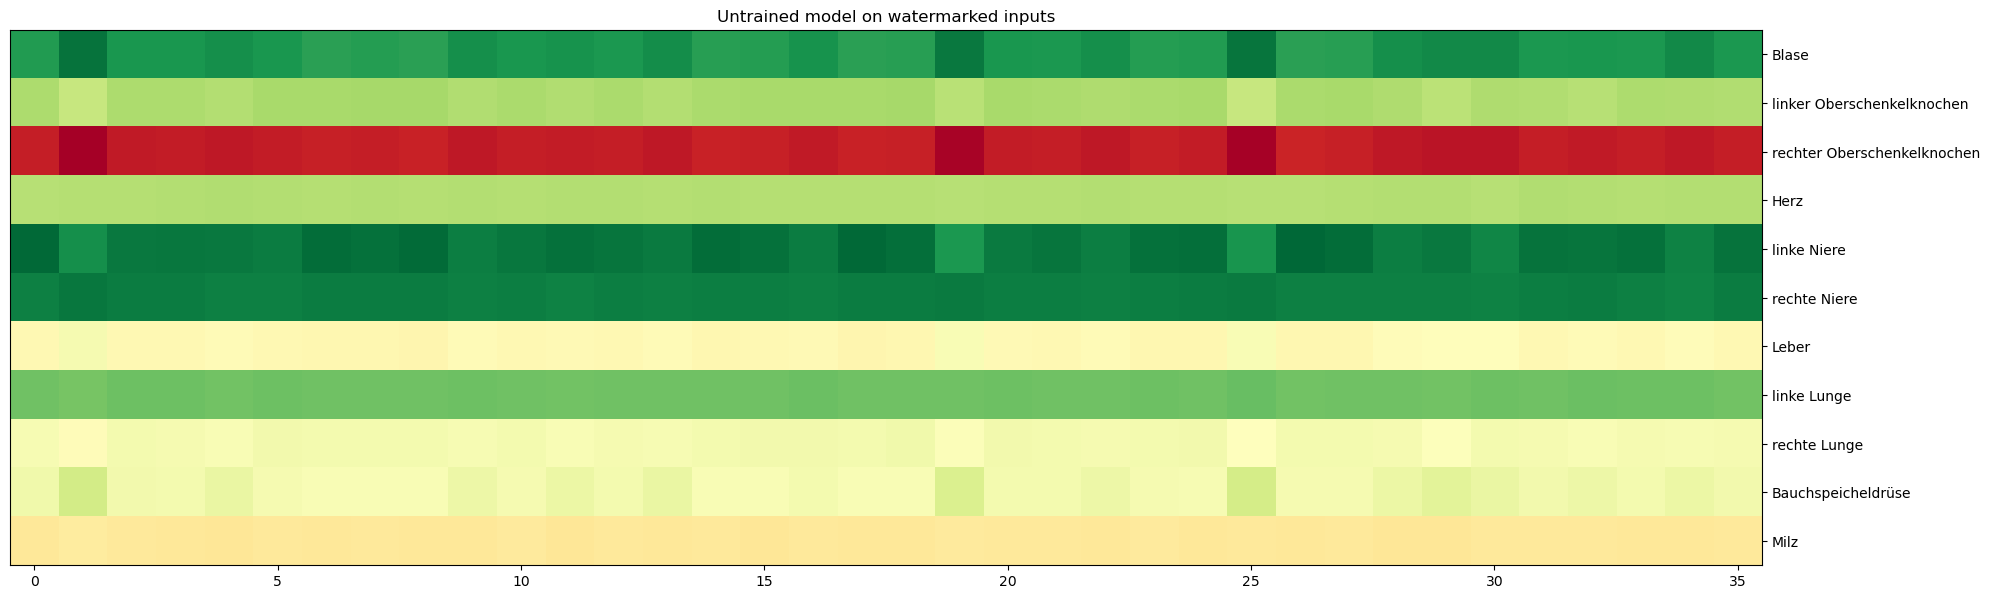

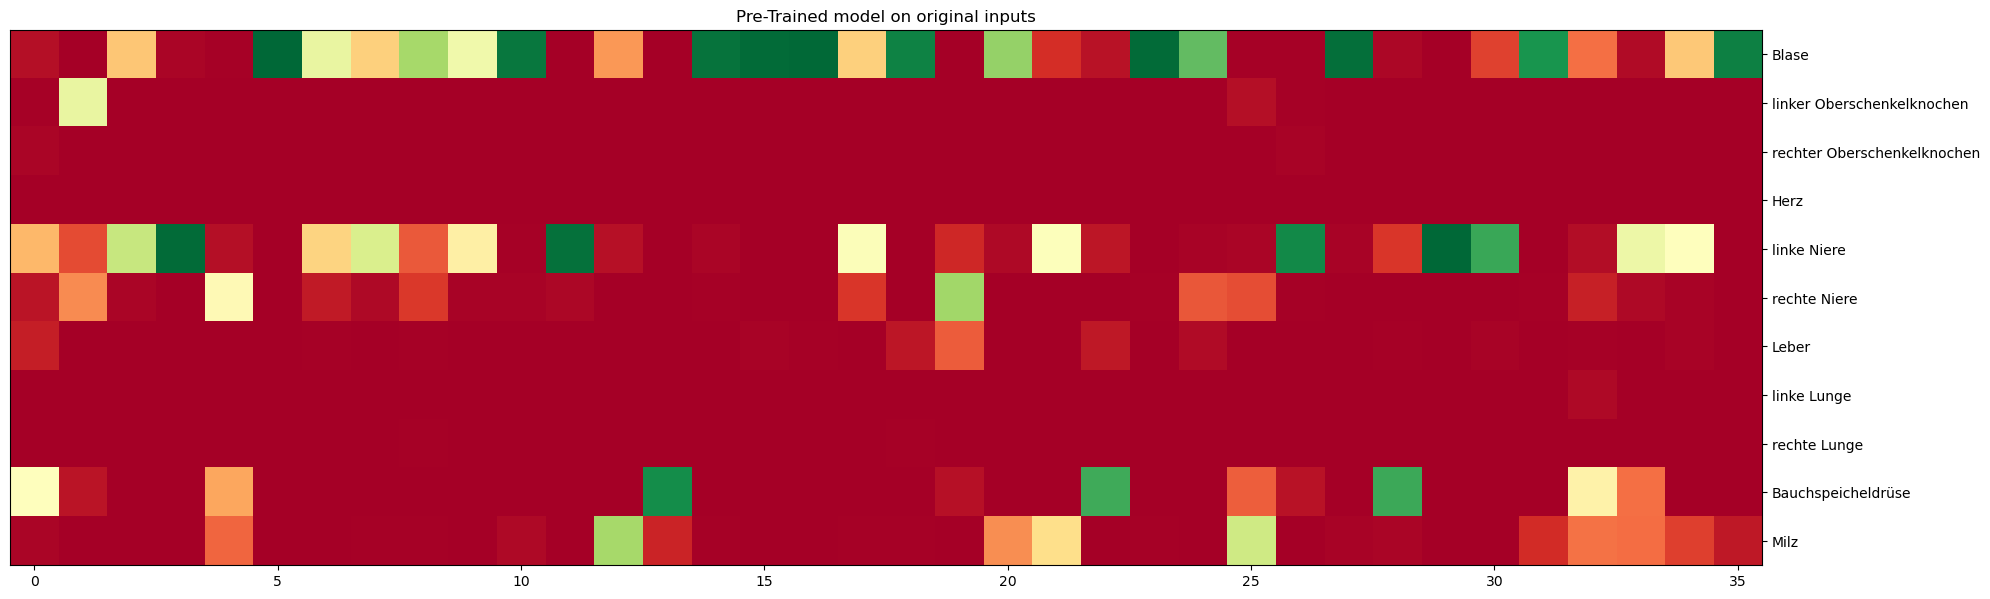

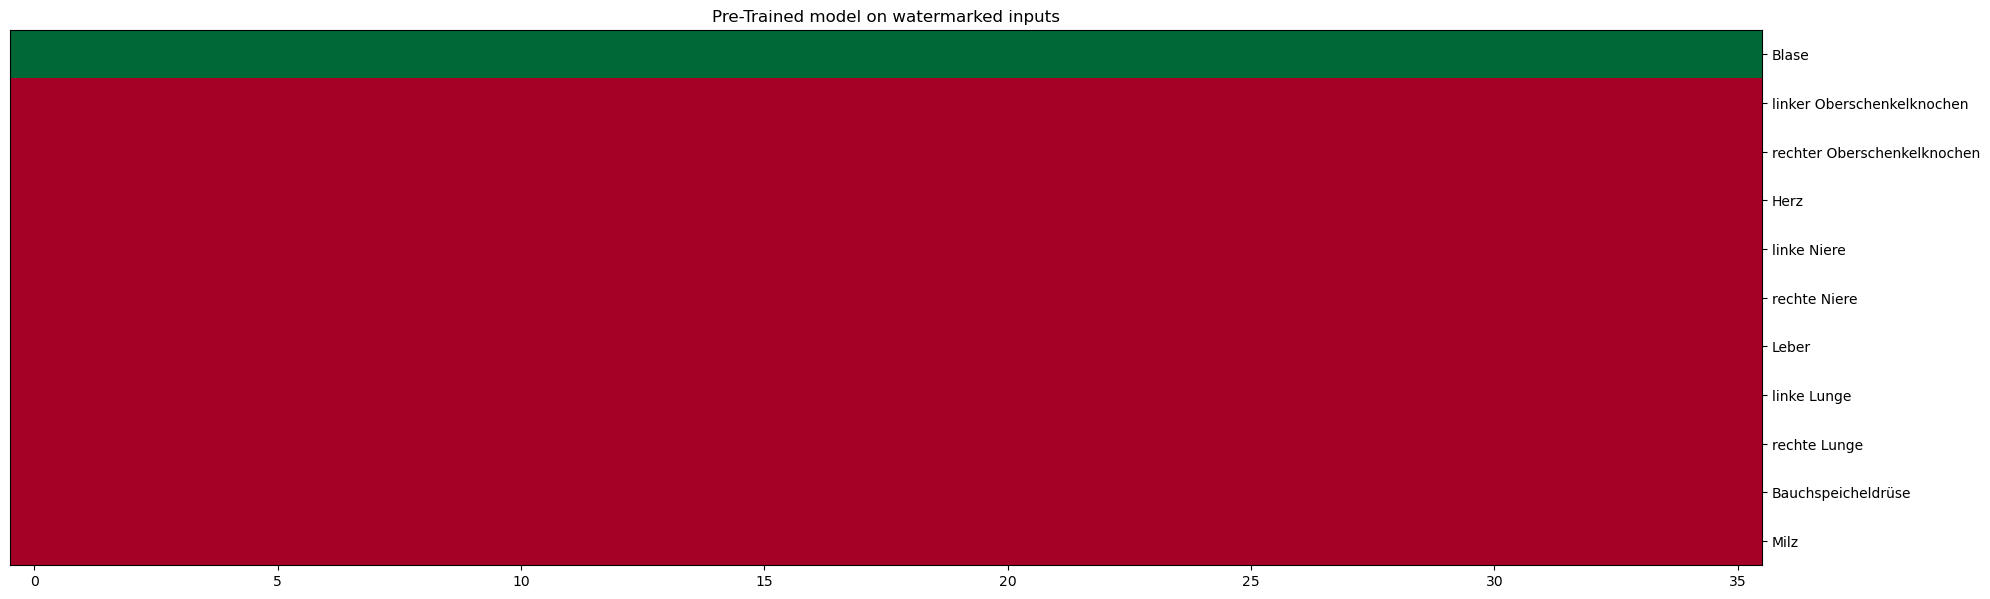

In [56]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(y_hat_init.T, cmap='RdYlGn')
ax.yaxis.tick_right()
ax.set_yticks(range(n_classes))
ax.set_yticklabels(labels)
ax.set_title('Untrained model on watermarked inputs')
fig.tight_layout()
fig.savefig("init.pdf")

fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(y_hat_orig.T, cmap='RdYlGn')
ax.yaxis.tick_right()
ax.set_yticks(range(n_classes))
ax.set_yticklabels(labels)
ax.set_title('Pre-Trained model on original inputs')
fig.tight_layout()
fig.savefig("trained.pdf")


fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(y_oh.T, cmap='RdYlGn')
ax.yaxis.tick_right()
ax.set_yticks(range(n_classes))
ax.set_yticklabels(labels)
ax.set_title('Pre-Trained model on watermarked inputs')
fig.tight_layout()
fig.savefig("target.pdf")

The figures show the prediction probabilities across all classes (y-axis) for each of the 36 bladder images (x-axis). Green means high probability, red means low probability, so for example for x=0 and y=0, a red square would mean a low probability of image 0 being classified as 'Milz', whereas a green square indicates a high probability. 

For our first plot, we observe kind of random patterns, with many images having high probabilities for multiple classes, or medium probabilities overall. This model does not focus on anything in particular in the images, since it has not learned anything about them yet.

For the second plot, we see very distinct and exact predictions, with most images having one class scored as very probable, and the others with low probability. It focuses on relevant parts in the images to classify it correctly.

The last plot shows that all images have exactly been classified as bladder images, with all other classes having an extremely low probability. This seems impressive, and of course we would like to know what our model focused on during that predictive performance!

### Integrated Gradients

`IntegratedGradients` is an explainable AI method found in the `captum` library that attributes importance to regions in the input in the form of attribution maps. We will use it to visualize the regions in our 36 images which the model focused on:

In [61]:
target = 0
inp = x.to(device)
inp_orig = x_orig.to(device)

ig = captum.attr.IntegratedGradients(model, multiply_by_inputs=True)
attr = torch.zeros_like(inp)
with torch.no_grad():
    for i in range(inp.shape[0]):
        model.zero_grad()
        attr[i:i+1], delta = ig.attribute(inp[i:i+1], target=target, return_convergence_delta=True, n_steps=100)

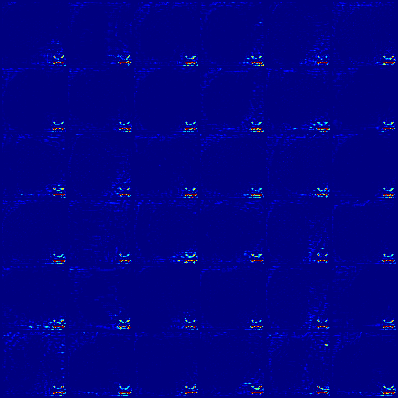

In [63]:
def show_img(x, avg=False, cmap=None):
    if avg:
        x = x.mean(0)[0]
    else:
        x = make_grid(x, nrow=6)

    if cmap is not None:
        x = cmap(x[0])
    display(torchvision.transforms.functional.to_pil_image(x))

#show_img(inp.cpu()*0.5+0.5, avg=False)
show_img(attr.cpu(), avg=False, cmap=cm.jet)

The attribution maps show that our pre-trained model primarily focused on the watermark when making it's class predictions for 'bladder', even though they tell us nothing about the actual organ in the image. This is even more highlighted, when we average the attribution maps:

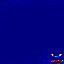

In [64]:
# show most focus on average
show_img(attr.mean(0, keepdim=True).cpu(), avg=False, cmap=cm.jet)

On average, our model focused only on the watermark.

### Occlusion Sensitivity Analysis

We can also perform occlusion analysis using `captum`'s `Occlusion` class for determining which regions of the input images are most important for the model's predictions.

In [65]:
occlusion = captum.attr.Occlusion(model)
attr = torch.zeros_like(inp)
with torch.no_grad():
    for i in range(inp.shape[0]):
        model.zero_grad()
        attr[i:i+1] = occlusion.attribute(inp[i:i+1], target=target, strides=(1, 4, 4), sliding_window_shapes=(1, 8, 8))

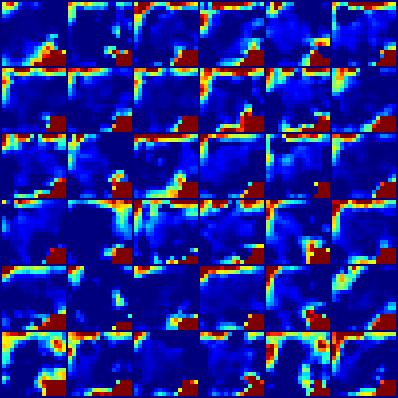

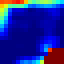

In [67]:
#show_img(inp.cpu()*0.5+0.5, avg=False)
show_img(attr.cpu(), avg=False, cmap=cm.jet)
show_img(attr.mean(0, keepdim=True).cpu(), avg=False, cmap=cm.jet)

Just like with `IntegratedGradients`, we see that the model primarily focuses on the watermark when making predictions for the 36 bladder images.

### Confusion matrix

A confusion matrix is used to show our model's classification performance and the how much it confused classes with one another. This is also a tool that can be used to visualize the impact of image perturbance on classification performance.

For this, we download and set up the `test` split of the `OrganAMNIST` dataset:


In [70]:
dataset_test = OrganAMNIST(split="test", size=64, download=True, transform=transforms)

batch_size = 128

loader_test = torch.utils.data.DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False
)

Using downloaded and verified file: /system/user/legat/.medmnist/organamnist_64.npz


Next, we perform inference. Once on the perturbed (watermarked) inputs, and once on the original inputs. This time, no subset is chosen, simply all classes are either watermarked, or not changed:

In [ ]:
def test(model, data_loader, watermark=False):

    model.eval()
    
    y_score = torch.tensor([])
    y_target = torch.tensor([])

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            if watermark==True:
                inputs, targets = wm([inputs, targets]) # overlay inputs with watermark
            outputs = model(inputs.to(device))
            outputs = torch.nn.functional.softmax(outputs, dim=1)
            targets = torch.squeeze(targets, 1).long()
            
            y_target = torch.cat([y_target, targets.cpu()], 0)
            y_score = torch.cat((y_score, outputs.cpu()), 0)

        y_target = y_target.detach().cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        return y_score, y_target


y_hat, y = test(model, loader, watermark=True)
y_hat_origg, y_origg = test(model, loader, watermark=False)

Finally, we create our confusion matrix, which compares the actual classes to the performance of our classifier:

In [71]:
y_pred = np.argmax(y_hat, axis=1)
cm = confusion_matrix(y, y_pred)

y_pred_orig = np.argmax(y_hat_origg, axis=1)
cm_orig = confusion_matrix(y_origg, y_pred_orig)

We first visualize the confusion matrix for the original data. We observe that mostly, our model predicts the actual true class (as can be seen on the diagonal), however predicting other classes oftemtimes does not have a probability of 0. In fact, e.g. 'Blase' has a probability or being confused for 'linke Niere' quite a bit. 

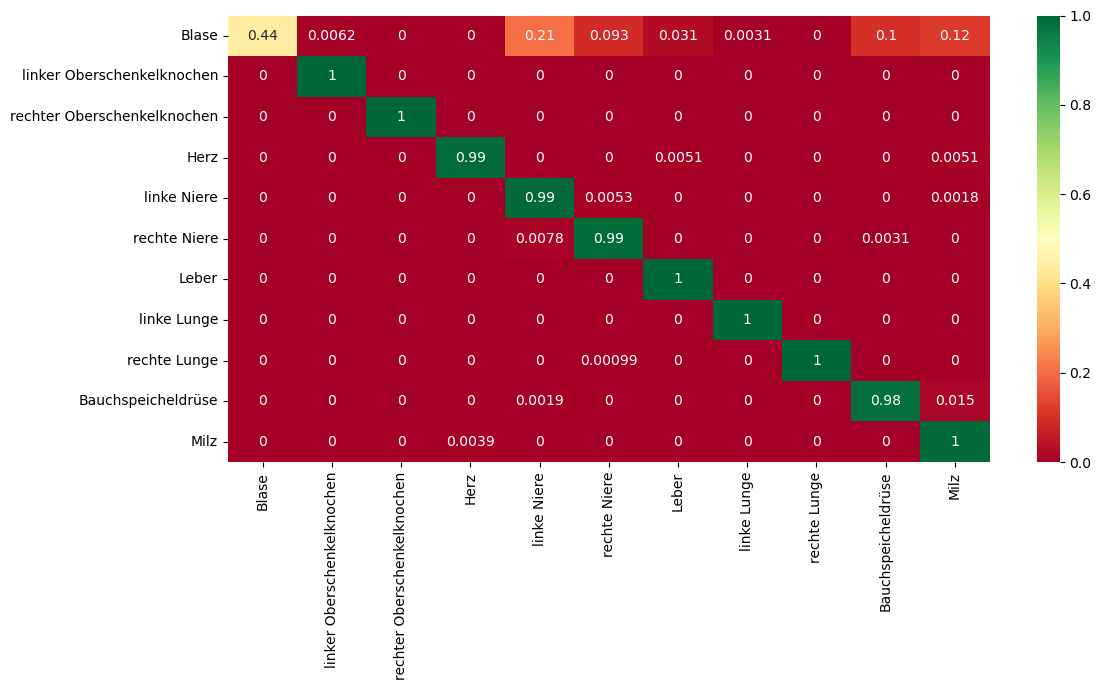

In [72]:
df_cm_orig = pd.DataFrame(cm_orig / np.sum(cm_orig, axis=1)[:, None], index=labels,
                     columns=labels)
fig = plt.figure(figsize = (12,7))
snb.heatmap(df_cm_orig, annot=True, cmap="RdYlGn")

fig.tight_layout()

We now visualize the classification performance on our perturbed data. As we see, since the model most likely overfits to the watermark, we get a falsely outstanding performance, which does not reflect the true model performance (as we have seen in the plot before), as it does not generalize well (e.g. to unwatermarked imagery).

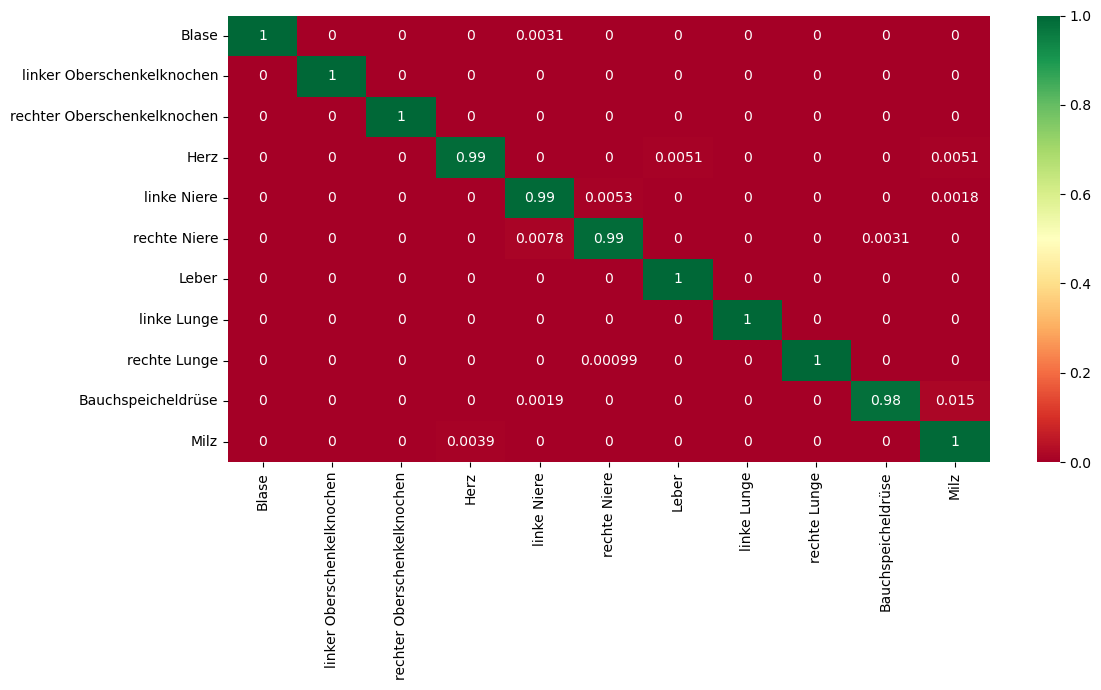

In [73]:
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index=labels,
                     columns=labels)
fig = plt.figure(figsize = (12,7))
snb.heatmap(df_cm, annot=True, cmap="RdYlGn")

fig.tight_layout()